# Solving Decentralizded Optimal Exchange Problem with BlueFog 

## 1. Optimal exchange problem

A network of $n$ nodes collaborate to solve an optimal exchange problem as follows:

$$\min_{\{x_i\}} \ \sum_{i=1}^n f_i(x_i) \quad \mathrm{s.t.}\ \sum_{i=1}^n x_i = 0.$$

This and related problems have a long history in economics, particularly in the theories
of market exchange, resource allocation, and general equilibrium. In this example, we will simulate how EXTRA, Exact Diffusion, and Gradient Tracking solve the above problem over a cluster of $n$ CPUs. 

## 2. KKT Condition

The Lagrangian function of the optimal exchange problem is:

$$L(x, y) = \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i)$$

where $y$ is the dual variable. The KKT condition is:

\begin{align}
\nabla f_i(x_i) + y & = 0, \quad \forall\ i\in [n] \\
\sum_{i=1}^n x_i & = 0. 
\end{align}

## 3. Experiment Setup

For simplicity, we assume $f_i(x) = \frac{1}{2}\|A_i x_i - b_i\|^2$ in which $A_i$ and $b_i$ are generated through uniform Gaussian distribution. 

### 3.1 Basic setup

Before generating the data, let's setup the basic experimental environment and make sure the communication between the rank and the driver is normal.

In [115]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3]

In [116]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 1 among 4 processes
[stdout:2] Hello, I am 2 among 4 processes
[stdout:3] Hello, I am 3 among 4 processes


In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

### 3.2 Generate data

In [5]:
# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None]

In [6]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021


In [7]:
%%px
m = 10 # number of rows of A
d = 5  # number of cols of A
torch.random.manual_seed(seed * bf.rank())  # make sure different rank has different seed
max_iters = 1000

A = torch.rand(m, d).to(torch.double)
b = torch.rand(m, 1).to(torch.double)

## 4. Achieve solution $x^\star$ with centralized ADMM

### 4.1 Algorithm

Centralized ADMM proposed in Ref. [[1]](https://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf) is as follows:

\begin{align}
x_i^{k+1} &= \arg\min_{x_i}\{ f_i(x_i) + \frac{\rho}{2}\|x_i - x_i^k + \bar{x}^k + u^k \|^2 \} \\
u^{k+1} &= u^k + \bar{x}^{k+1}
\end{align}

where $\bar{x}^k = ({1}/{n})\sum_{i=1}^n x_i^k$ and $y^k = \rho u^k$. When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, the above recursion becomes

\begin{align}
x_i^{k+1} &= \arg\min_{x_i} \big( \frac{1}{2}\|A_i x_i - b_i\|^2 + \frac{\rho}{2}\|x_i - x_i^k + \bar{x}^k + u^k \|^2 \big) = (\rho I + A_i^T A_i)^{-1} (A_i^T b_i + \rho x_i^k - \bar{x}^k - u^k) \nonumber \\
u^{k+1} &= u^k + \bar{x}^{k+1}
\end{align}

In [8]:
%%px

# centralized ADMM
def centralized_ADMM_one_recursion(x, x_bar, u, IpATA):
    
    x = IpATA.mm(A.T.mm(b) + rho*x - x_bar - u)
    x_bar = bf.allreduce(x, average=True)
    u += x_bar
    
    return x, x_bar, u

In [9]:
%%px

# initialization
rho = 1

x = torch.zeros(d, 1)
x_bar = torch.zeros(d, 1)
u = torch.zeros(d, 1)
IpATA = torch.inverse(rho * torch.eye(d) + A.T.mm(A))

In [10]:
# run algorithm
maxite = 1000
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px x, x_bar, u = centralized_ADMM_one_recursion(x, x_bar, u, IpATA)
    
# store solution
%px x_sol = x.clone()

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


### 4.2 Check optimality

When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, the KKT condition of the optimal exchange problem becomes

$$A_i^T(A_i x_i - b) + y = 0, \quad \sum_{i=1}^n x_i = 0$$

After running the following cell, you should observe that the above KKT conditons are satisfied witht the newly achieved $x_i^k$, $\bar{x}^k$ and $y^k$

In [11]:
%%px

# check optimality

y = u*rho
print(torch.norm(A.T.mm(A.mm(x_sol) - b) + y, p=2))
print(torch.norm(x_bar, p=2))

[stdout:0] 
tensor(1.6342e-07, dtype=torch.float64)
tensor(1.6342e-07, dtype=torch.float64)
[stdout:1] 
tensor(1.6342e-07, dtype=torch.float64)
tensor(1.6342e-07, dtype=torch.float64)
[stdout:2] 
tensor(1.6342e-07, dtype=torch.float64)
tensor(1.6342e-07, dtype=torch.float64)
[stdout:3] 
tensor(1.6342e-07, dtype=torch.float64)
tensor(1.6342e-07, dtype=torch.float64)


## 5. Optimal exchange: the dual problem

Recall the Lagrangian function of the optimal exchange problem:

$$L(x, y) = \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i)$$

The dual function is thus given by:

$$g(y) = \min_{\{x_i\}} \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i) = \sum_{i=1}^n \min_{x_i}\{f_i(x_i) + y^T x_i \} = - \sum_{i=1}^n \max_{x_i}\ \{-f_i(x_i) - y^T x_i\} = - \sum_{i=1}^n f_i^*(-y)$$

As a result, the dual problem is

$$\min_y \sum_{i=1}^n f_i^*(-y), \quad \mbox{where} \quad f_i^*(-y) = \max_{x_i} \{-f_i(x_i) - y^T x_i\} = -f_i(x_i^*) - y^T x_i^*$$

Now we define $F_i(y) = f_i^*(-y) = -f_i(x_i^*) - y^T x_i^*$, then the dual problem becomes a **consensus** problem:

\begin{align}
\label{consensus}
\min_y \sum_{i=1}^n F_i(y).
\end{align}

Note that the above problem is **differentiable**, and each local gradient is $\nabla F_i(y) = - x_i^* = - \arg\min_{x_i}\{f_i(x_i) + y^T x_i\}$. 

When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, we have $\nabla F_i(y) = - x_i^* = - (A_i^T A_i)^{-1}(A_i^T b_i - y)$.

## 6. Decentralized algorithms

Since the dual problem is the consensus problem, there exist many well-known decentralized algorithms to solve it effectively. In this example, we examine EXTRA [[2]](https://arxiv.org/abs/1404.6264), Exact Diffusion [[3]](https://arxiv.org/abs/1702.05122), and Gradient Tracking [[4]](https://arxiv.org/abs/1607.03218).

### 6.1 EXTRA

To solve the dual consensus problem, EXTRA has the following recursions:

\begin{align}
y_i^{k+1} & = \sum_{j=1}^n \bar{w}_{ij}\big( 2 y_j^k - y_j^{k-1}\big) - \alpha \big(g_i(y_i^{k}) - g_i(y_i^{k-1})\big), \quad k=1,2,\cdots  \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{align}

where $g_j(y) = \nabla F_j(y)$, and we set the initialization $y_i^{1} = y_i^{0} = 0$, and let $g_i(y_i^{0}) = 0$. The weight $\bar{w}_{ij}$ is defined as:

\begin{align}
\bar{w}_{ij}=
\begin{cases}
(1+w_{ii})/2 & \mbox{if $i=j$} \\
w_{ij}/2 & \mbox{otherwise}
\end{cases}
\end{align}

In [40]:
%%px

# EXTRA
def EXTRA_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights):
    
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    yn = bf.neighbor_allreduce(2*y - yp, self_weight, neighbor_weights, name='y')
    yn = yn - lr*(g - gp)
    gp = g.clone()
    yp = y.clone()
    y  = yn.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_extra.append(torch.sqrt(averaged_relative_error))
    
    return y, yp, gp

In [63]:
%%px

# initialization
lr = 0.1
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
yp = torch.zeros(d, 1)
gp = torch.zeros(d, 1)
record_extra = []

In the following cell, we set the topology as the exponential-2 graph, and scale weights from $w$ to $\bar{w}$.

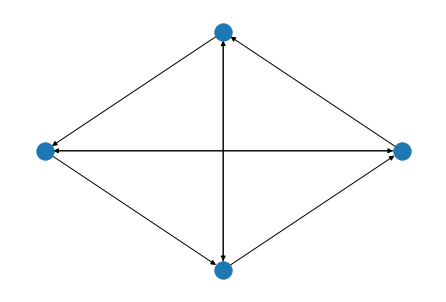

In [118]:
# plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [119]:
%%px

# set topology and generate weight w_bar = (w + 1)/2
bf.set_topology(topology_util.ExponentialGraph(bf.size()))
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(
    topology, bf.rank())

if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)
        
self_weight = (self_weight+1)/2
for k, v in neighbor_weights.items():
    neighbor_weights[k] = v/2
    
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:0] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333
self weights: 0.6666666666666666

neighbor weights:
2 0.16666666666666666
3 0.16666666666666666


In [65]:
# run EXTRA
maxite = 2000

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, yp, gp = EXTRA_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights)

Progress 0/2000
Progress 100/2000
Progress 200/2000
Progress 300/2000
Progress 400/2000
Progress 500/2000
Progress 600/2000
Progress 700/2000
Progress 800/2000
Progress 900/2000
Progress 1000/2000
Progress 1100/2000
Progress 1200/2000
Progress 1300/2000
Progress 1400/2000
Progress 1500/2000
Progress 1600/2000
Progress 1700/2000
Progress 1800/2000
Progress 1900/2000


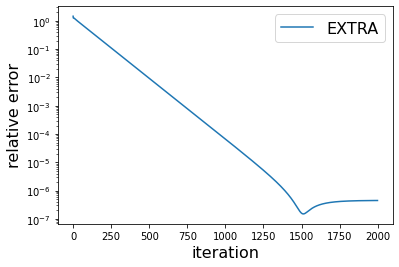

In [66]:
# pull averaged relative error list from node 0 
record_extra_0 = dview.pull('record_extra', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_extra_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['EXTRA'],fontsize=16)

**Note**: 

- The relative error is around $10^{-7}$ because the KKT conditon of the centralized solution is with the precision level $10^{-7}$.

- In the $y$-axis, the averaged relative error is computed as $\sqrt{\frac{1}{n}\sum_{i=1}^n \|x_i^k - x_i^\star\|^2/\|x_i^\star\|^2}$

### 6.2 Exact Diffusion

To solve the dual consensus problem, EXTRA has the following recursions:

\begin{align}
y_i^{k+1} & = \sum_{j=1}^n \bar{w}_{ij}\big( 2 y_j^k - y_j^{k-1} - \alpha (g_i(y_i^{k}) - g_i(y_i^{k-1})) \big), \quad k=1,2,\cdots  \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{align}

where $g_j(y) = \nabla F_j(y)$, and we set the initialization $y_i^{1} = y_i^{0} = 0$, and let $g_i(y_i^{0}) = 0$. The weight $\bar{w}_{ij}$ is defined the same as that in EXTRA algorithm. It is observed that Exact Diffusion is almost the same as EXTRA, except that the combination matrix $\bar{w}_{ij}$ is also associated with the gradient.

In [67]:
%%px

# Exact Diffusion
def Exact_diffusion_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights):
    
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    yn = bf.neighbor_allreduce(2*y - yp - lr*(g - gp), self_weight, neighbor_weights, name='y')
    gp = g.clone()
    yp = y.clone()
    y  = yn.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_exact_diffusion.append(torch.sqrt(averaged_relative_error))
    
    return y, yp, gp

In [104]:
%%px

# initialization
lr = 0.1
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
yp = torch.zeros(d, 1)
gp = torch.zeros(d, 1)
record_exact_diffusion = []

In [105]:
%%px

# set topology and generate weight w_bar = (w + 1)/2
bf.set_topology(topology_util.ExponentialGraph(bf.size()))
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(
    topology, bf.rank())

if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)
        
self_weight = (self_weight+1)/2
for k, v in neighbor_weights.items():
    neighbor_weights[k] = v/2
    
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:0] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333
self weights: 0.6666666666666666

neighbor weights:
2 0.16666666666666666
3 0.16666666666666666


In [106]:
# run Exact Diffusion
maxite = 2000

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, yp, gp = Exact_diffusion_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights)

Progress 0/2000
Progress 100/2000
Progress 200/2000
Progress 300/2000
Progress 400/2000
Progress 500/2000
Progress 600/2000
Progress 700/2000
Progress 800/2000
Progress 900/2000
Progress 1000/2000
Progress 1100/2000
Progress 1200/2000
Progress 1300/2000
Progress 1400/2000
Progress 1500/2000
Progress 1600/2000
Progress 1700/2000
Progress 1800/2000
Progress 1900/2000


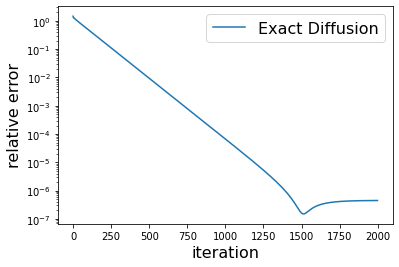

In [107]:
# pull averaged relative error list from node 0 
record_exact_diffusion_0 = dview.pull('record_exact_diffusion', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_exact_diffusion_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['Exact Diffusion'],fontsize=16)

### 6.3 Gradient tracking

To solve the dual consensus problem, gradient tracking has the following recursions:

\begin{align}
y_i^{k+1} &= \sum_{j=1}^n w_{ij}(y_j^k + \alpha z_j^k) \\
z_i^{k+1} &= \sum_{j=1}^n w_{ij}\big(z_j^k + g_j(y_j^{k+1}) - g_j(y_j^{k})\big) \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{align}

where $g_j(y) = \nabla F_j(y)$ and $z_i^0 = g_i(y_i^0)$

In [12]:
%%px

# gradient tracking
def gradient_tracking_one_recursion(y, z, gp, ATA, A, b, x_sol, lr):
    
    y = bf.neighbor_allreduce(y - lr*z, name='y')
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    z = bf.neighbor_allreduce(z + g - gp, name='z')
    gp = g.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_gt.append(torch.sqrt(averaged_relative_error))
    
    return y, z, gp

In [13]:
%%px

# initialization
lr = 0.5
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
gp = ATA.mm(A.T.mm(b) - y)
z = ATA.mm(A.T.mm(b) - y)
record_gt = []

In [14]:
# run gradient tracking
maxite = 400

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, z, gp = gradient_tracking_one_recursion(y, z, gp, ATA, A, b, x_sol, lr)

Progress 0/400
Progress 100/400
Progress 200/400
Progress 300/400


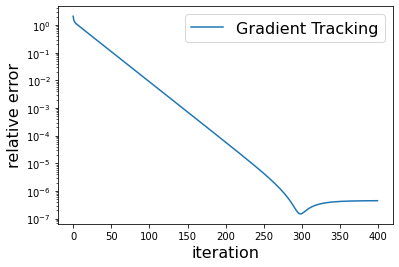

In [15]:
# pull averaged relative error list from node 0 
record_gt_0 = dview.pull('record_gt', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_gt_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['Gradient Tracking'],fontsize=16)

#### gradient tracking

In [125]:
%%px

lr = 1
maxite = 1000
record_gt = []

ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
gp = ATA.mm(A.T.mm(b) - y)
z = ATA.mm(A.T.mm(b) - y)

# print(bf.rank())
# print(ATA)
# print(A)
# print(b)
# print(gp)
# print(z)
# print(ATA.mm(A.T.mm(A)))

# Y = np.zeros((num_nodes, d))
# Psi_prev = np.zeros((num_nodes, d))
# X_sol = X_star.copy()

# Gp = getGrad(ATA, A_dict, b_dict, Y)
# Z = getGrad(ATA, A_dict, b_dict, Y)

for ite in range(maxite):

#     # gradient tracking
#     Y = W@(Y - lr*Z)
#     G = getGrad(ATA, A_dict, b_dict, Y)
#     X = -G
#     Z = W@(Z + G - Gp)
#     Gp = G.copy()   


    y = bf.neighbor_allreduce(y - lr*z, name='y')
#     y = bf.allreduce(y - lr*z, average=True)
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    z = bf.neighbor_allreduce(z + g - gp, name='z')
#     z = bf.allreduce(z + g - gp, average=True)
    gp = g.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    msd = bf.allreduce(dist**2, average=True)
    
    record_gt.append(torch.sqrt(msd))

In [126]:
record_gt_0 = dview.pull('record_gt', block=True, targets=0)

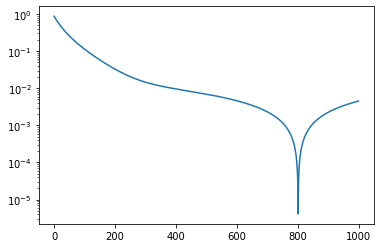

In [127]:
%matplotlib inline
plt.semilogy(record_gt_0)